# Report: smart contracts topic modeling

# Obiettivo del progetto
Una delle principali applicazioni del natural language
processing è l’estrazione  automatica dei  topics discussi
dalle persone all’interno di un grande volume di testi.
L’obiettivo del progetto è quello di usare LDA per estrarre
i principali topics presenti in un  dataset di Smart
contracts. Si procedera con:

- l'estrazione del linguaggio naturale degli smart contracts;

- l'individuazione dei topics e la percentuale di contribuzione per ogni topic;


## LDA: Latent Dirichlet Allocation.
L’approccio LDA per la topic modeling considera ogni
documento come una collezione di topics in certe
proporzioni. Ogni topic a sua volta  è una collezione
di keywords. Anche semplicemente guardando le keywords,
si possono già identificare vari topics.

Per ottenere una buona segregazione dei topics sono indispensabili:

- La qualità del preprocessamento del testo
- La varietà dei topics n
- La scelta di un algoritmo di topic modeling
- Il numero di topics che dati all’algoritmo
- I parametri di tuning dell’algoritmo

## Creazione del corpus

Dopo aver clonato il repository (https://github.com/smartbugs/smartbugs-wild) nel quale è contenuto il
dataset di smart contract che si andrà ad analizzare,
è stata aggiunta la cartella 'contracts' al progetto
contenete i contratti in formato '.sol'.
Tramite la funzione CategorizedPlaintextCorpusReader
importata da 'nltk.corpus' è stato creato un corpus
contentente gli smart contracts.

In [1]:
from nltk.corpus import CategorizedPlaintextCorpusReader
import nltk

root_dir = 'contracts'

contract_corpus = CategorizedPlaintextCorpusReader(
    './%s/' % root_dir,
    r'.*\.sol',
    cat_pattern=r'(\w+)/*',
    encoding='latin-1'
)
contracts = [(contract_corpus.raw(fileid), category)
              for category in contract_corpus.categories()
              for fileid in contract_corpus.fileids(category)]


data = [str(nltk.Text(contract)) for contract in contracts]
print(data[:1])

['<Text: pragma solidity ^0.4.23;\r\n\r\n// File: openzeppelin-solidity/contracts/ownership/Ownable.sol\r\n\r\n/**\r\n * @title Ownable\r\n * @dev The Ownable contract has an owner address, and provides basic authorization control\r\n * functions, this simplifies the implementation of "user permissions".\r\n */\r\ncontract Ownable {\r\n  address public owner;\r\n\r\n\r\n  event OwnershipTransferred(address indexed previousOwner, address indexed newOwner);\r\n\r\n\r\n  /**\r\n   * @dev The Ownable constructor sets the original `owner` of the contract to the sender\r\n   * account.\r\n   */\r\n  function Ownable() public {\r\n    owner = msg.sender;\r\n  }\r\n\r\n  /**\r\n   * @dev Throws if called by any account other than the owner.\r\n   */\r\n  modifier onlyOwner() {\r\n    require(msg.sender == owner);\r\n    _;\r\n  }\r\n\r\n  /**\r\n   * @dev Allows the current owner to transfer control of the contract to a newOwner.\r\n   * @param newOwner The address to transfer ownership to.\r\

## Tokenizzazione e pulizia del testo

Gli Smart Contracts sono programmi scritti nel linguaggio
Solidity. Per questo motivo, prima di procedere con la
topic modeling è stato svolto un importantissimo lavoro
di pulizia del testo, in particolare creando delle
stopwords prese dal linguaggio Solidity e altre parole
tipiche degli Smart Contract che però non aggiungono
nessun significato al fine della topic modeling.


In [2]:
from nltk.corpus import stopwords

english_stopwords = stopwords.words('english')

english_stopwords.extend(
    ['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get',
     'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot',
     'lack',
     'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

otherstopwords = ['http', 'https', 'file', 'token', 'owner', 'b', 'c', 'text', 'index', 'amount', 'github', 'com',
                  'referal', 'percent', 'percentage', 'length', 'total', 'account', 'sub', 'add', 'success',
                  'successful', 'name', 'sender', 'erc', 'standard', 'basic', 'approval', 'safe', 'allow', 'allowance',
                  'supply', 'balance', 'eth', 'ethereum', 'source', 'blockchain', 'sol', 'gas', 'decimal', 'unit',
                  'initial', 'enough', 'check', 'overflow', 'recipient', 'set', 'give', 'display', 'creator', 'div',
                  'rev', 'min', 'max', 'mul', 'callable', 'update', 'last', 'current', 'array', 'already', 'approve',
                  'code',
                  'subtract', 'addition', 'receive', 'addition', 'implement', 'user']
english_stopwords.extend(otherstopwords)

solidity_stopwords = ['pragma', 'bytes', 'bytes32', 'type', 'int', 'string', 'fallback', 'bool', 'var', 'msgvalue',
                      'balance', 'plus', 'minus', 'symbol', 'geq', 'gt', 'eq', 'hex', '&&', 'and', 'or', 'not',
                      'condexpr', 'call', 'delegatecall', 'send', 'transfer', 'exprnil', 'pnil', 'pcons', 'view',
                      'visibility', 'payable', 'title', 'this', 'solidity', 'uint', 'function', 'meth', 'value',
                      'return',
                      'returns', 'castinterf', 'interface', 'declaration', 'if', 'else', 'ifelse', 'assigmenet',
                      'sequence', 'any_funct', 'contract_ast', 'cast', 'addr', 'address', 'mapping', 'dev', 'event',
                      'require', 'struct', 'constant', 'constructor', 'param', 'public', 'private', 'contract',
                      'modifier', 'msg', 'true', 'false', 'pure', 'delete', 'payable', 'throw',
                      'memory', 'new', 'internal', 'ether', 'arg', 'args', 'dynargs', 'timestamp', 'datasource',
                      'gaslimit', 'library', 'id', 'using', 'encode', 'external', 'buffer', 'safemath', 'revert',
                      'emit',
                      'assert', 'callcode', 'error']

english_stopwords.extend(solidity_stopwords)

Inoltre, considerando che Solidity è un linguaggio di programmazione,
prima di procedere è stato utile separare le parole scritte in CamelCase.

In [3]:
import re

def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    words=[m.group(0).replace('_', '') for m in matches]
    return words

Una volta definite le stopwords, si è proceduto a creare delle funzioni
per rimuoverle, per la creazione di bigrammi e per lemmatizzare il testo,
ossia alla riduzione dei termini al proprio lemma.
I termini che sono stati considerati sono:
- nomi (‘NOUN’)
- aggettivi ('ADJ')
- verbi ('VERB')
- avverbi ('ADV')

I bigrammi sono 2 parole che compaiono frequentemente insieme nel
documento.
Utilizzando “gensim.model.Phrases” è possibile implementare facilmente
i bigrammi.

In [4]:
import gensim.utils
import spacy

def preprocess(doc, deacc=False, min_len=3, max_len=15):
    tokens = [
        token for token in gensim.utils.tokenize(doc, lower=False, deacc=deacc, errors='ignore')
        if min_len <= len(token) <= max_len and not token.startswith('_')
    ]
    return tokens


def sent_to_words(sentences):
    for sent in sentences:
        # Remove id contracts
        sent = re.sub('\S*0x\S*\s?', '', sent)

        # Remove new line characters
        sent = re.sub('\s+', ' ', sent)

        # Remove distracting single quotes
        sent = re.sub("\'", "", sent)

        # Remove charaters with exponent
        sent = re.sub("\S*½|¼|¾|¹|²|³|º\S", '', sent)

        # Remove alphanumerical words with lenght 64 charaters (adress)
        sent = re.sub("\w{64}", "", sent)

        yield (preprocess(str(sent), deacc=True))  # deacc=True removes punctuations

def list_of_contracts(documents):
    nli = []
    result = []
    for doc in documents:
        nli = []
        for w in doc:
            if len(w) > 1:
                for wo in w:
                    nli.append(wo)
            if len(w)==1:
                nli.append(w[0])
        result.append(nli)
    return result

def process_words(texts,
                  stop_words=english_stopwords,
                  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'],
                  bigram_mod=None,
                  trigram_mod=None):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in preprocess(str(doc)) if word.lower() not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser',
                                                'ner'])  # keeping only tagger component (for efficiency). spacy.load('en', disable=['parser', 'ner', 'textcat'])
    nlp.max_length = 10000000
    contracts = []
    for doc in texts:
        # print("sent: " ,sent)
        sent = []
        for token in doc:
            sent.append([word.lower() for word in camel_case_split(token) if word.lower() not in english_stopwords])
        contracts.append(sent)

    result = list_of_contracts(contracts)
    texts_out = []
    for docum in result:
        document = nlp("".join(str(docum)))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in document if
                                   token.pos_ in allowed_postags]))
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in preprocess(str(doc)) if word.lower() not in english_stopwords] for doc in texts_out]
    return texts_out

data_words = list(sent_to_words(data))

bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100)  # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# trigram_mod = gensim.models.phrases.Phraser(trigram)



data_ready = process_words(
        data_words,
        bigram_mod=bigram_mod,
        # trigram_mod=trigram_mod
    )

print(data_ready[:1])

/Users/stefanocaria/PycharmProjects/master/venv/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[['openzeppelin', 'ownership', 'ownable', 'ownable', 'ownable', 'provide', 'authorization', 'control', 'simplifie', 'implementation', 'permission', 'ownable', 'previous', 'ownable', 'original', 'ownable', 'control', 'ownership', 'openzeppelin', 'ownership', 'claimable', 'claimable', 'extension', 'ownable', 'ownership', 'claim', 'accept', 'claimable', 'ownable', 'pende', 'pende', 'pende', 'pende', 'ownership', 'pende', 'pende', 'finalize', 'claim', 'ownership', 'pende', 'pende', 'pende', 'utility', 'global', 'pause', 'future', 'trusttoken', 'reference', 'admin', 'pause', 'transaction', 'signal', 'fork', 'support', 'fork', 'asset', 'back', 'global', 'pause', 'claimable', 'pause', 'pause', 'notice', 'pause', 'pause', 'pause', 'notice', 'pause', 'pause', 'notice']]


## Costruzione del topic model
I due principali input nella creazione del LDA topic model
sono il dizionario (id2word) e il corpus.

In [5]:
from gensim import corpora
import pprint

# Create Dictionary
id2word = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

Ovviamente un altro parametro importante per la costruzione del modello è il numero di topic.

Inizialmente, possiamo costruire un modello con un numero arbitrario
di topics, dove ogni topic è una combinazione di keywords e ogni keyword contribuisce a topic con un certo peso. Si possono osservare le keywords e il relativo peso.


In [ ]:

# Build LDA model
print("building LDA model...")
n_topics= 14
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=n_topics,
                                                random_state=100,
                                                chunksize=1000,
                                                update_every= 500,
                                                passes=20,
                                                alpha='auto',
                                                iterations=400,
                                                per_word_topics=True)

pprint(lda_model.print_topics())


## Grid search

Con la Grid search vengono costruiti modelli LDA multipli per
tutte le possibili combinazioni dei param values che si trovano
nel param_grid (composto da diversi numeri di topics e
diversi valori per learning decay).

In [65]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV

data_for_sktlearn=[]
data_for_sklearn=[str(text) for text in data_ready]
vectorizer = CountVectorizer(analyzer='word',
                                 min_df=10,  # minimum reqd occurences of a word
                                 stop_words= 'english',  # remove stop words
                                 lowercase=True,  # convert all words to lowercase
                                 token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                                 # max_features=50000,             # max number of uniq words
                                 )

data_vectorized = vectorizer.fit_transform(data_for_sklearn)

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='online')

# Init Grid Search Class
print("GridSearchCV...")
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))



GridSearchCV...
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 30}
Best Log Likelihood Score:  -14123926.196291644
Model Perplexity:  311.6077424155882


Dalla grid search risulta che il miglior modello è quello con n_topics= 30  e learning_decay= 0.7

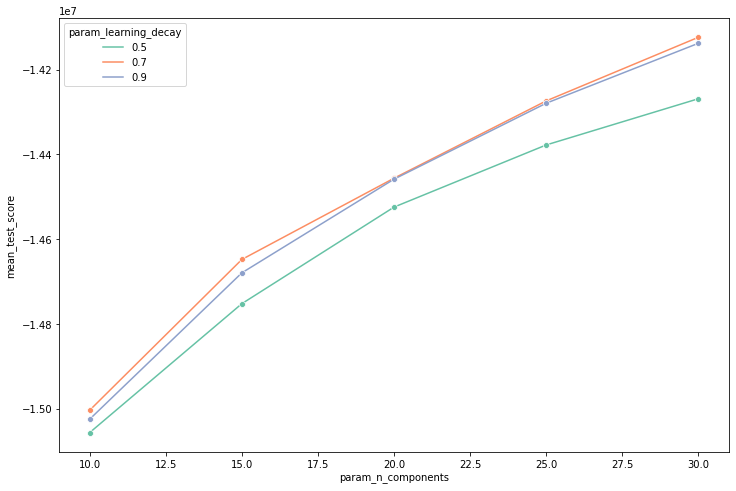

In [72]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


results = pd.DataFrame(model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12, 8))

sns.lineplot(data=results,
                 x='param_n_components',
                 y='mean_test_score',
                 hue='param_learning_decay',
                 palette=current_palette,
                 marker='o'
                 )

plt.show()

Il grafico sembra suggerire che la Likelihood aumenta
con l'aumentare del numero di topics. Tuttavia, come verrà
analizzato tra poco verrà, per la scelta del numero di topics
si terrà conto della Coherence in quanto ( come dimostrato da recenti studi ) spesso ottimizzare gli indicatori
Likelhood e Perplexity potrebbe produrre topics poco interpretabili dall'uomo
.

## Model Perplexity and Coherence Score

Per giudicare la bontà del modello creato si possono utilizzare
la Perplexity e la Coherence. Più il valore della perplexity è
basso migliore sarà il modello. La perplexity però, è un
indicatore poco utile per la qualità dei topics.
Per quanto riguarda la Coherence sembra essere più utile
per la scelta del numero di topics (k). Si sono creati diversi
modelli con differenti ‘k’ e si è scelto come valore ottimale di ‘k’
quello che evidenzia la fine di una una rapida crescita.

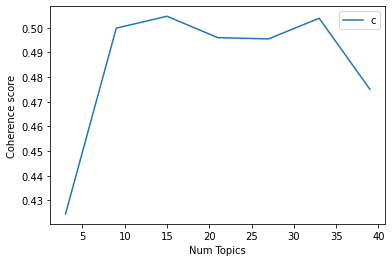

Num Topics = 3  has Coherence Value of 0.4245
Num Topics = 9  has Coherence Value of 0.4998
Num Topics = 15  has Coherence Value of 0.5046
Num Topics = 21  has Coherence Value of 0.496
Num Topics = 27  has Coherence Value of 0.4955
Num Topics = 33  has Coherence Value of 0.5038
Num Topics = 39  has Coherence Value of 0.475


In [8]:
from gensim.models import CoherenceModel
import warnings



def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    warnings.filterwarnings('ignore')
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_state=100, chunksize=1000, update_every=500, iterations=400, passes=20,
                                                alpha='auto', per_word_topics=True, eval_every=None)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


print("computing coherence values for different number of topics...")
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready,
                                                            start=3, limit=40, step=6)

In [ ]:
from matplotlib import pyplot as plt
#Print the coherence scores
limit = 40;
start = 3;
step = 6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Il modello che mostra un Coherence value più alto è quello
con un numero di topics pari a 15.



In [11]:
from pprint import pprint
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.041*"role" + 0.038*"spender" + 0.015*"price" + 0.013*"ierc" + '
  '0.012*"minter" + 0.011*"asset" + 0.011*"burn" + 0.011*"remove" + '
  '0.011*"time" + 0.011*"mint"'),
 (1,
  '0.051*"burn" + 0.036*"frozen" + 0.033*"target" + 0.029*"number" + '
  '0.022*"spend" + 0.022*"freeze" + 0.020*"block" + 0.019*"spender" + '
  '0.016*"mint" + 0.016*"price"'),
 (2,
  '0.046*"spender" + 0.035*"mint" + 0.026*"spend" + 0.025*"pause" + '
  '0.024*"ownable" + 0.022*"fund" + 0.021*"specify" + 0.018*"issue" + '
  '0.017*"old" + 0.016*"number"'),
 (3,
  '0.051*"spender" + 0.023*"notice" + 0.021*"remain" + 0.016*"datum" + '
  '0.015*"currency" + 0.012*"wallet" + 0.012*"fee" + 0.011*"sufficient" + '
  '0.011*"spend" + 0.008*"able"'),
 (4,
  '0.016*"storage" + 0.014*"auction" + 0.013*"datum" + 0.013*"self" + '
  '0.012*"asset" + 0.012*"list" + 0.010*"notice" + 0.009*"keccak" + '
  '0.009*"price" + 0.008*"wad"'),
 (5,
  '0.043*"transaction" + 0.039*"investor" + 0.030*"deposit" + 0.022*"fee" + '
  '0

Ad esempio il topic 0 è rappresentato da  '0.041*"role" + 0.038*"spender" + 0.015*"price" + 0.013*"ierc" +
0.012*"minter" + 0.011*"asset" + 0.011*"burn" + 0.011*"remove" + 0.011*"time" + 0.011*"mint"'.

Queste sono le 10 parole che contribuiscono maggiormente al
topic 0. Il peso della parola “role” sul topic 0 è di 0.041.
Il peso riflette l’importanza della parola su quel topic.

## pyLDAvis

In [ ]:
%matplotlib inline
import pyLDAvis
from pyLDAvis.gensim_models import prepare
import pyLDAvis.gensim_models
import warnings
lda_model= optimal_model
pyLDAvis.enable_notebook()

def visualize_topics(lda_model, corpus):
    warnings.filterwarnings("ignore", category= DeprecationWarning)
    vis = prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='mmds')
    pyLDAvis.save_html(vis, './report/topic_modeling_visualization.html')



visualize_topics(lda_model, corpus)


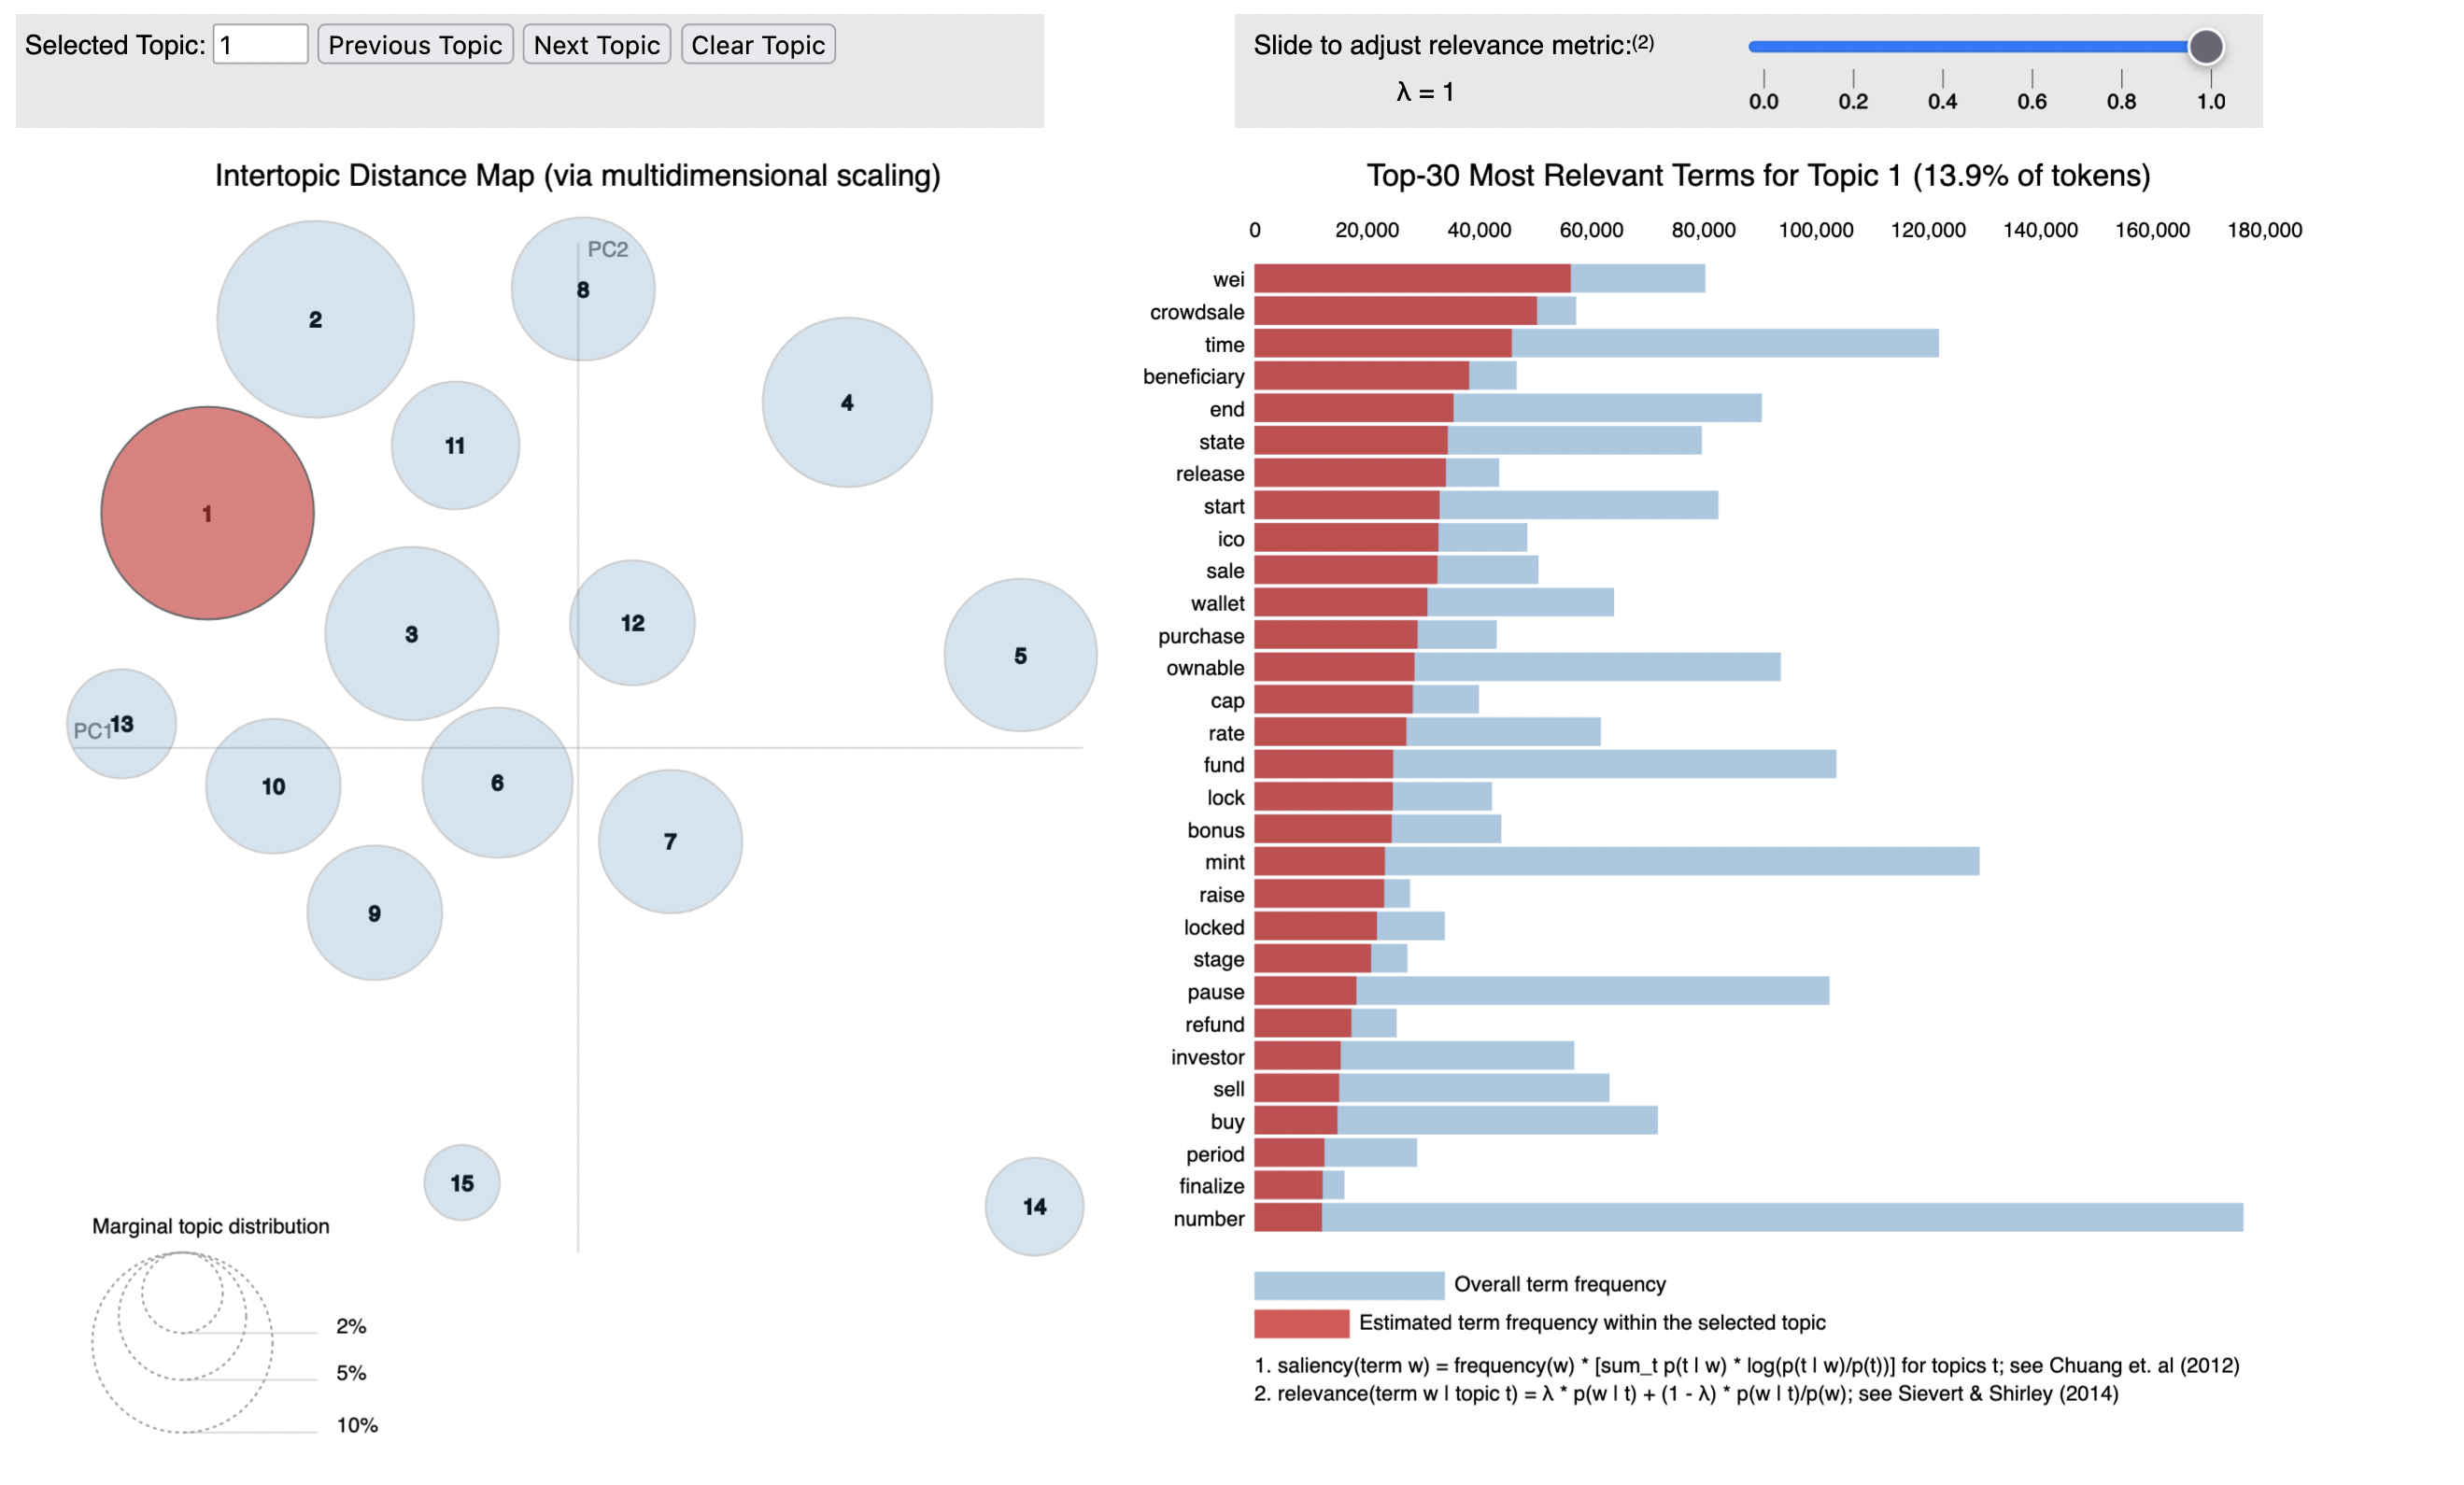

In [49]:
from IPython.display import Image
Image(filename='img/pyLDAvis.png')

Come si può notare non si evidenziano particolari over-lapping.
Il fatto che non ci sia sovrapposizione tra i topics indica una
buona clusterizzazione a livello di topics.

- Topic 1: crowdsale (vendita di criptovalute o token);
- Topic 2: mint new coins;
- Topic 3: auction e nft (non-fungible-tokens);
- Topic 4: oracle;
- Topic 5: gioco/casinò;
- Topic 6: loan (prestiti);
- Topic 7: digitalizzazione di asset (datum);
- Topic 8: contratti self destruction/ burn;
- Topic 9: trading;
- Topic 10: investimenti;
- Topic 11: access token : per richiedere l’accesso a una risorsa protetta (ogni wallet ha un set limitato di poteri e vantaggi.  Role, bearer, access,);
- Topic 12: bet/Jackpot (scommesse);
- Topic 13: compravendita tickets
- Topic 14: Binance smart chain (trading ultraveloce e decentralizzato: BAS è un token );
- Topic 15: compravendita di futures;


## Clusters
La clusterizzazione degli smart contracts è stata fatta principalmente
grazie a 2 librerie:
- bokeh per la visualizzazione grafica;
- TSNE (per l’algoritmo di features reduction).  É un algoritmo
che utilizza una T-distribution per l’individuazione delle
componenti principali.

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, save


def show_topic_clusters(lda_model, corpus, n_topics=15):
    topic_weights = []
    for i, row_list in enumerate(lda_model[corpus]):
        topic_weights.append([w for i, w in row_list[0]])

    # Array of topic weights
    arr = pd.DataFrame(topic_weights).fillna(0).values
    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)

    # tSNE Dimension Reduction
    # t-distributed Stochastic Neighbor Embedding
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)

    # Plot the Topic Clusters using Bokeh
    output_notebook()
    file_name = 'report/topic_modeling_clusters.html'
    output_file(file_name)

    mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
    plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
                  plot_width=900, plot_height=700)
    plot.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1], color=mycolors[topic_num])
    save(plot)

# Visualize HTML reports of topics and topic clusters
n_topics=15
show_topic_clusters(lda_model, corpus, n_topics=n_topics)

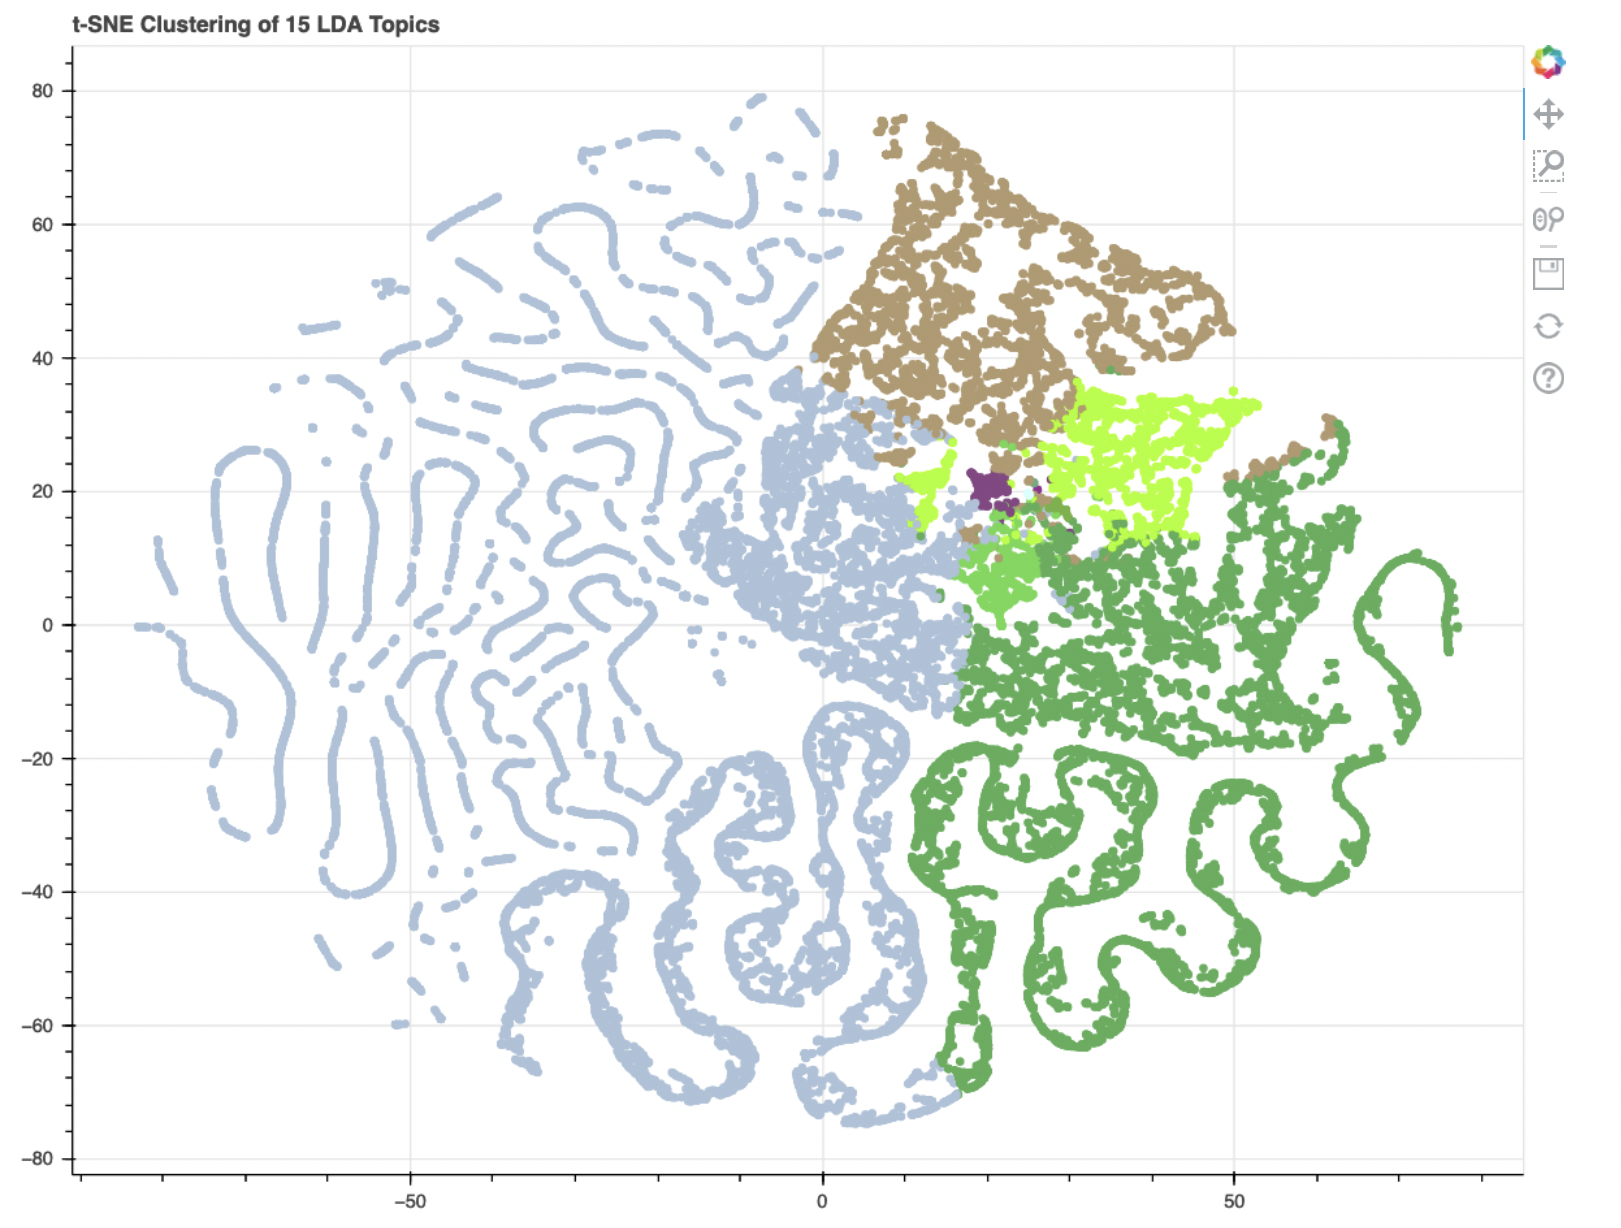

In [70]:
from IPython.display import Image
Image(filename='img/clusters.png')


## Elbow Method
Per stimare il numero di cluster 'k' possiamo considerare anche il
cosiddetto Elbow Method.

[422054225.1468861, 359271559.9505889, 330923949.52629745, 307801605.1712844, 293303443.94030476, 282440144.47279054, 272797578.6590601, 263083325.5373722, 256556640.83062798, 246528376.24342003, 244888623.8262662, 234701924.1848041, 229863674.53282812, 226780953.37022108, 224332712.32071283, 219797940.17632532, 218216685.058558, 217353911.6139556]


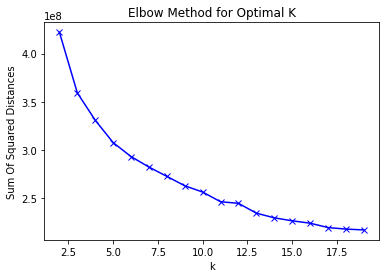

In [68]:
from sklearn.cluster import KMeans
def getBestKForKMeans(data_vectorized, maxClusters=20):
    sumOfSquareDistance=[]
    K=range(2, maxClusters)
    for k in K:
        km = KMeans(n_clusters=k)
        km= km.fit(data_vectorized)
        sumOfSquareDistance.append(km.inertia_)
    print(sumOfSquareDistance)
    plt.plot(K, sumOfSquareDistance, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum Of Squared Distances')
    plt.title('Elbow Method for Optimal K')
    plt.show()

getBestKForKMeans(data_vectorized, maxClusters=20)

Il punto di cambio di pendenza sembra essere intorno a k=15.

## Topic dominante per ciascun documento


In [13]:
import pandas as pd

def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        if len(row_list) == 0:
            continue
        row = row_list[0] if ldamodel.per_word_topics else row_list
        if isinstance(row, tuple):
            row = [row]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_ready)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic.head(20)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0             0             2.0              0.5549   
1             1             4.0              0.9983   
2             2             4.0              0.6918   
3             3             0.0              0.6218   
4             4             3.0              0.5953   
5             5             5.0              0.9991   
6             6             4.0              0.7125   
7             7            11.0              0.6310   
8             8             5.0              0.8974   
9             9             5.0              0.8977   
10           10             0.0              0.6042   
11           11             0.0              0.2358   
12           12             4.0              0.9983   
13           13            13.0              0.5656   
14           14             4.0              0.9982   
15           15             3.0              0.5414   
16           16            13.0              0.6430   
17           17             0.0              0.7528   
18           18             1.0              0.3668   
19           19             0.0              0.7528   

                                             Keywords  \
0   spender, mint, spend, pause, ownable, fund, sp...   
1   storage, auction, datum, self, asset, list, no...   
2   storage, auction, datum, self, asset, list, no...   
3   role, spender, price, ierc, minter, asset, bur...   
4   spender, notice, remain, datum, currency, wall...   
5   transaction, investor, deposit, fee, count, da...   
6   storage, auction, datum, self, asset, list, no...   
7   bet, pause, block, number, game, jackpot, win,...   
8   transaction, investor, deposit, fee, count, da...   
9   transaction, investor, deposit, fee, count, da...   
10  role, spender, price, ierc, minter, asset, bur...   
11  role, spender, price, ierc, minter, asset, bur...   
12  storage, auction, datum, self, asset, list, no...   
13  order, admin, fee, price, rate, game, trade, s...   
14  storage, auction, datum, self, asset, list, no...   
15  spender, notice, remain, datum, currency, wall...   
16  order, admin, fee, price, rate, game, trade, s...   
17  role, spender, price, ierc, minter, asset, bur...   
18  burn, frozen, target, number, spend, freeze, b...   
19  role, spender, price, ierc, minter, asset, bur...   

                                                 Text  
0   [openzeppelin, ownership, ownable, ownable, ow...  
1   [proxy, trust, registry, proxy, proxy, proxy, ...  
2   [utility, registry, val, attribute, registry, ...  
3   [ownable, ownable, ownable, provide, authoriza...  
4   [metapod, version, author, age, notice, create...  
5   [optimization, enable, evm, version, constanti...  
6   [optimization, enable, immutable, create, fact...  
7   [rlp, due, unexplained, bug, slightly, differe...  
8   [optimization, enable, tpl, extend, jurisdicti...  
9   [optimization, enable, tpl, extend, jurisdicti...  
10  [free, free, free, free, gnosismulti, sig, wal...  
11  [blaze, remain, rescue, method, rescue, mistak...  
12  [proxy, proxy, proxy, possibility, delegate, f...  
13  [experimentalabi, encoder, free, free, free, f...  
14  [proxy, proxy, proxy, possibility, delegate, f...  
15  [metamorphic, factory, author, age, notice, cr...  
16  [receiver, qty, datum, datum, ariyax, ariyax, ...  
17  [foton, main, ftn, foton, burnable, spender, r...  
18  [nrm, main, nrm, neuromachine, eternal, burnab...  
19  [foton, main, ftn, foton, burnable, spender, r...

## Documento maggiormente rappresentativo per ciascun topic

Alcune volte le keywords non sono sufficienti per comprendere
di che topics si tratta. Per facilitare la comprensione dei topics
si può andare a leggere il documento che ha contribuito maggiormente
alla formazione del topic.

In [35]:
sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf,
                                          grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                         axis=0)

    # Reset Index
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head(30)

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.9996   
1         1.0              0.9997   
2         2.0              0.9997   
3         3.0              0.9999   
4         4.0              0.9999   
5         5.0              0.9998   
6         6.0              1.0000   
7         7.0              0.9999   
8         8.0              0.9998   
9         9.0              0.9999   
10       10.0              0.9999   
11       11.0              0.9998   
12       12.0              1.0000   
13       13.0              0.9999   
14       14.0              1.0000   

                                             Keywords  \
0   role, spender, price, ierc, minter, asset, bur...   
1   burn, frozen, target, number, spend, freeze, b...   
2   spender, mint, spend, pause, ownable, fund, sp...   
3   spender, notice, remain, datum, currency, wall...   
4   storage, auction, datum, self, asset, list, no...   
5   transaction, investor, deposit, fee, count, da...   
6   futfuture, future, piyuroma, vest, vested, dis...   
7   oraclize, price, oraclizequery, api, self, sig...   
8   wei, crowdsale, time, beneficiary, end, state,...   
9   put, opt, change, bas, dec, mar, volume, strik...   
10  round, player, pot, end, plyr, key, datum, aff...   
11  bet, pause, block, number, game, jackpot, win,...   
12  number, reach, listingsbinance, upgrade, agent...   
13  order, admin, fee, price, rate, game, trade, s...   
14  price, fee, dividend, sell, number, payout, po...   

                                                 Text  
0   [nodemodule, openzeppelin, access, role, role,...  
1   [blob, master, eipseip, spender, remain, spend...  
2   [craft, crypo, craft, crypto, form, idea, mmmm...  
3   [flatten, solidifiercoina, math, operation, sa...  
4   [linear, star, release, azimuth, network, impo...  
5   [operator, oneday, mindep, maxdep, admin, star...  
6   [piyuroma, piyuroma, piyuroma, simple, deduct,...  
7   [oraclizesrl, ltdpermission, herebygranted, fr...  
8   [math, operation, safety, automatically, divid...  
9   [vocci, vocci, vocci, simple, deduct, spender,...  
10  [mojekyll, islandinc, long, version, justosump...  
11  [soliumdisable, linebreakstyle, fund, jackpot,...  
12  [listingsbinance, number, reach, listingsbinan...  
13  [dmex, base, miumget, reserve, reserve, affili...  
14  [experimental, copyright, trading, inclicense,...

## WordCloud: visualizzazione topics

Un ulteriore modo per avere una rappresentazione
grafica e intuitiva dei topics si ha utilizzando WordCloud.

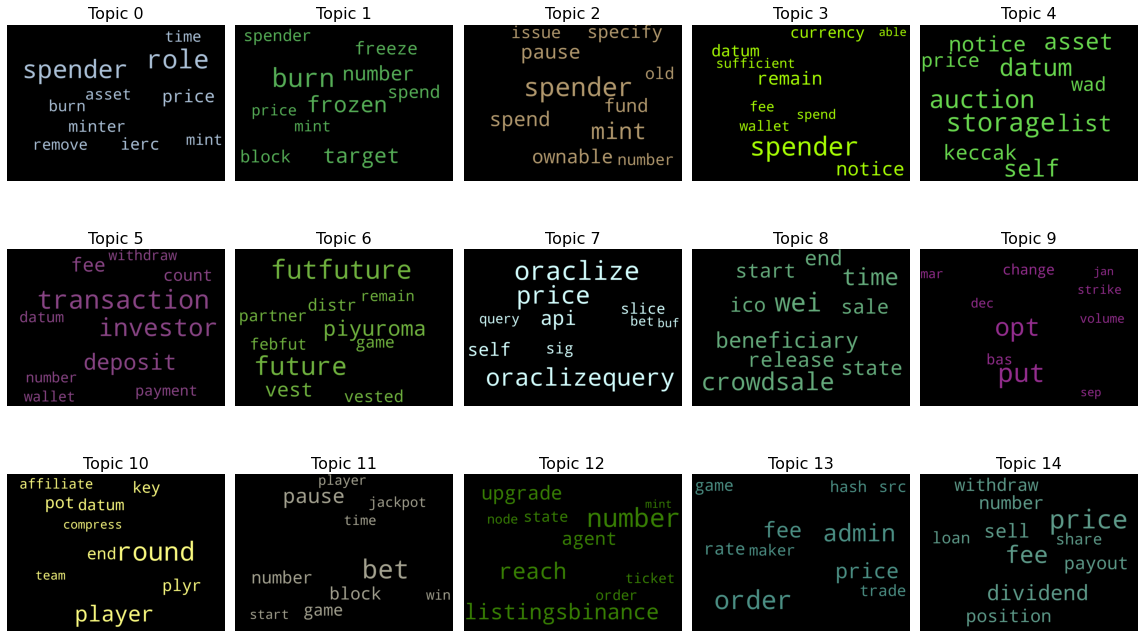

In [52]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=english_stopwords,
                      background_color='black',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_topics=15)


fig, axes = plt.subplots(3, 5, figsize=(16, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten(), ):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Distribution of Document Word Count by Dominant topic

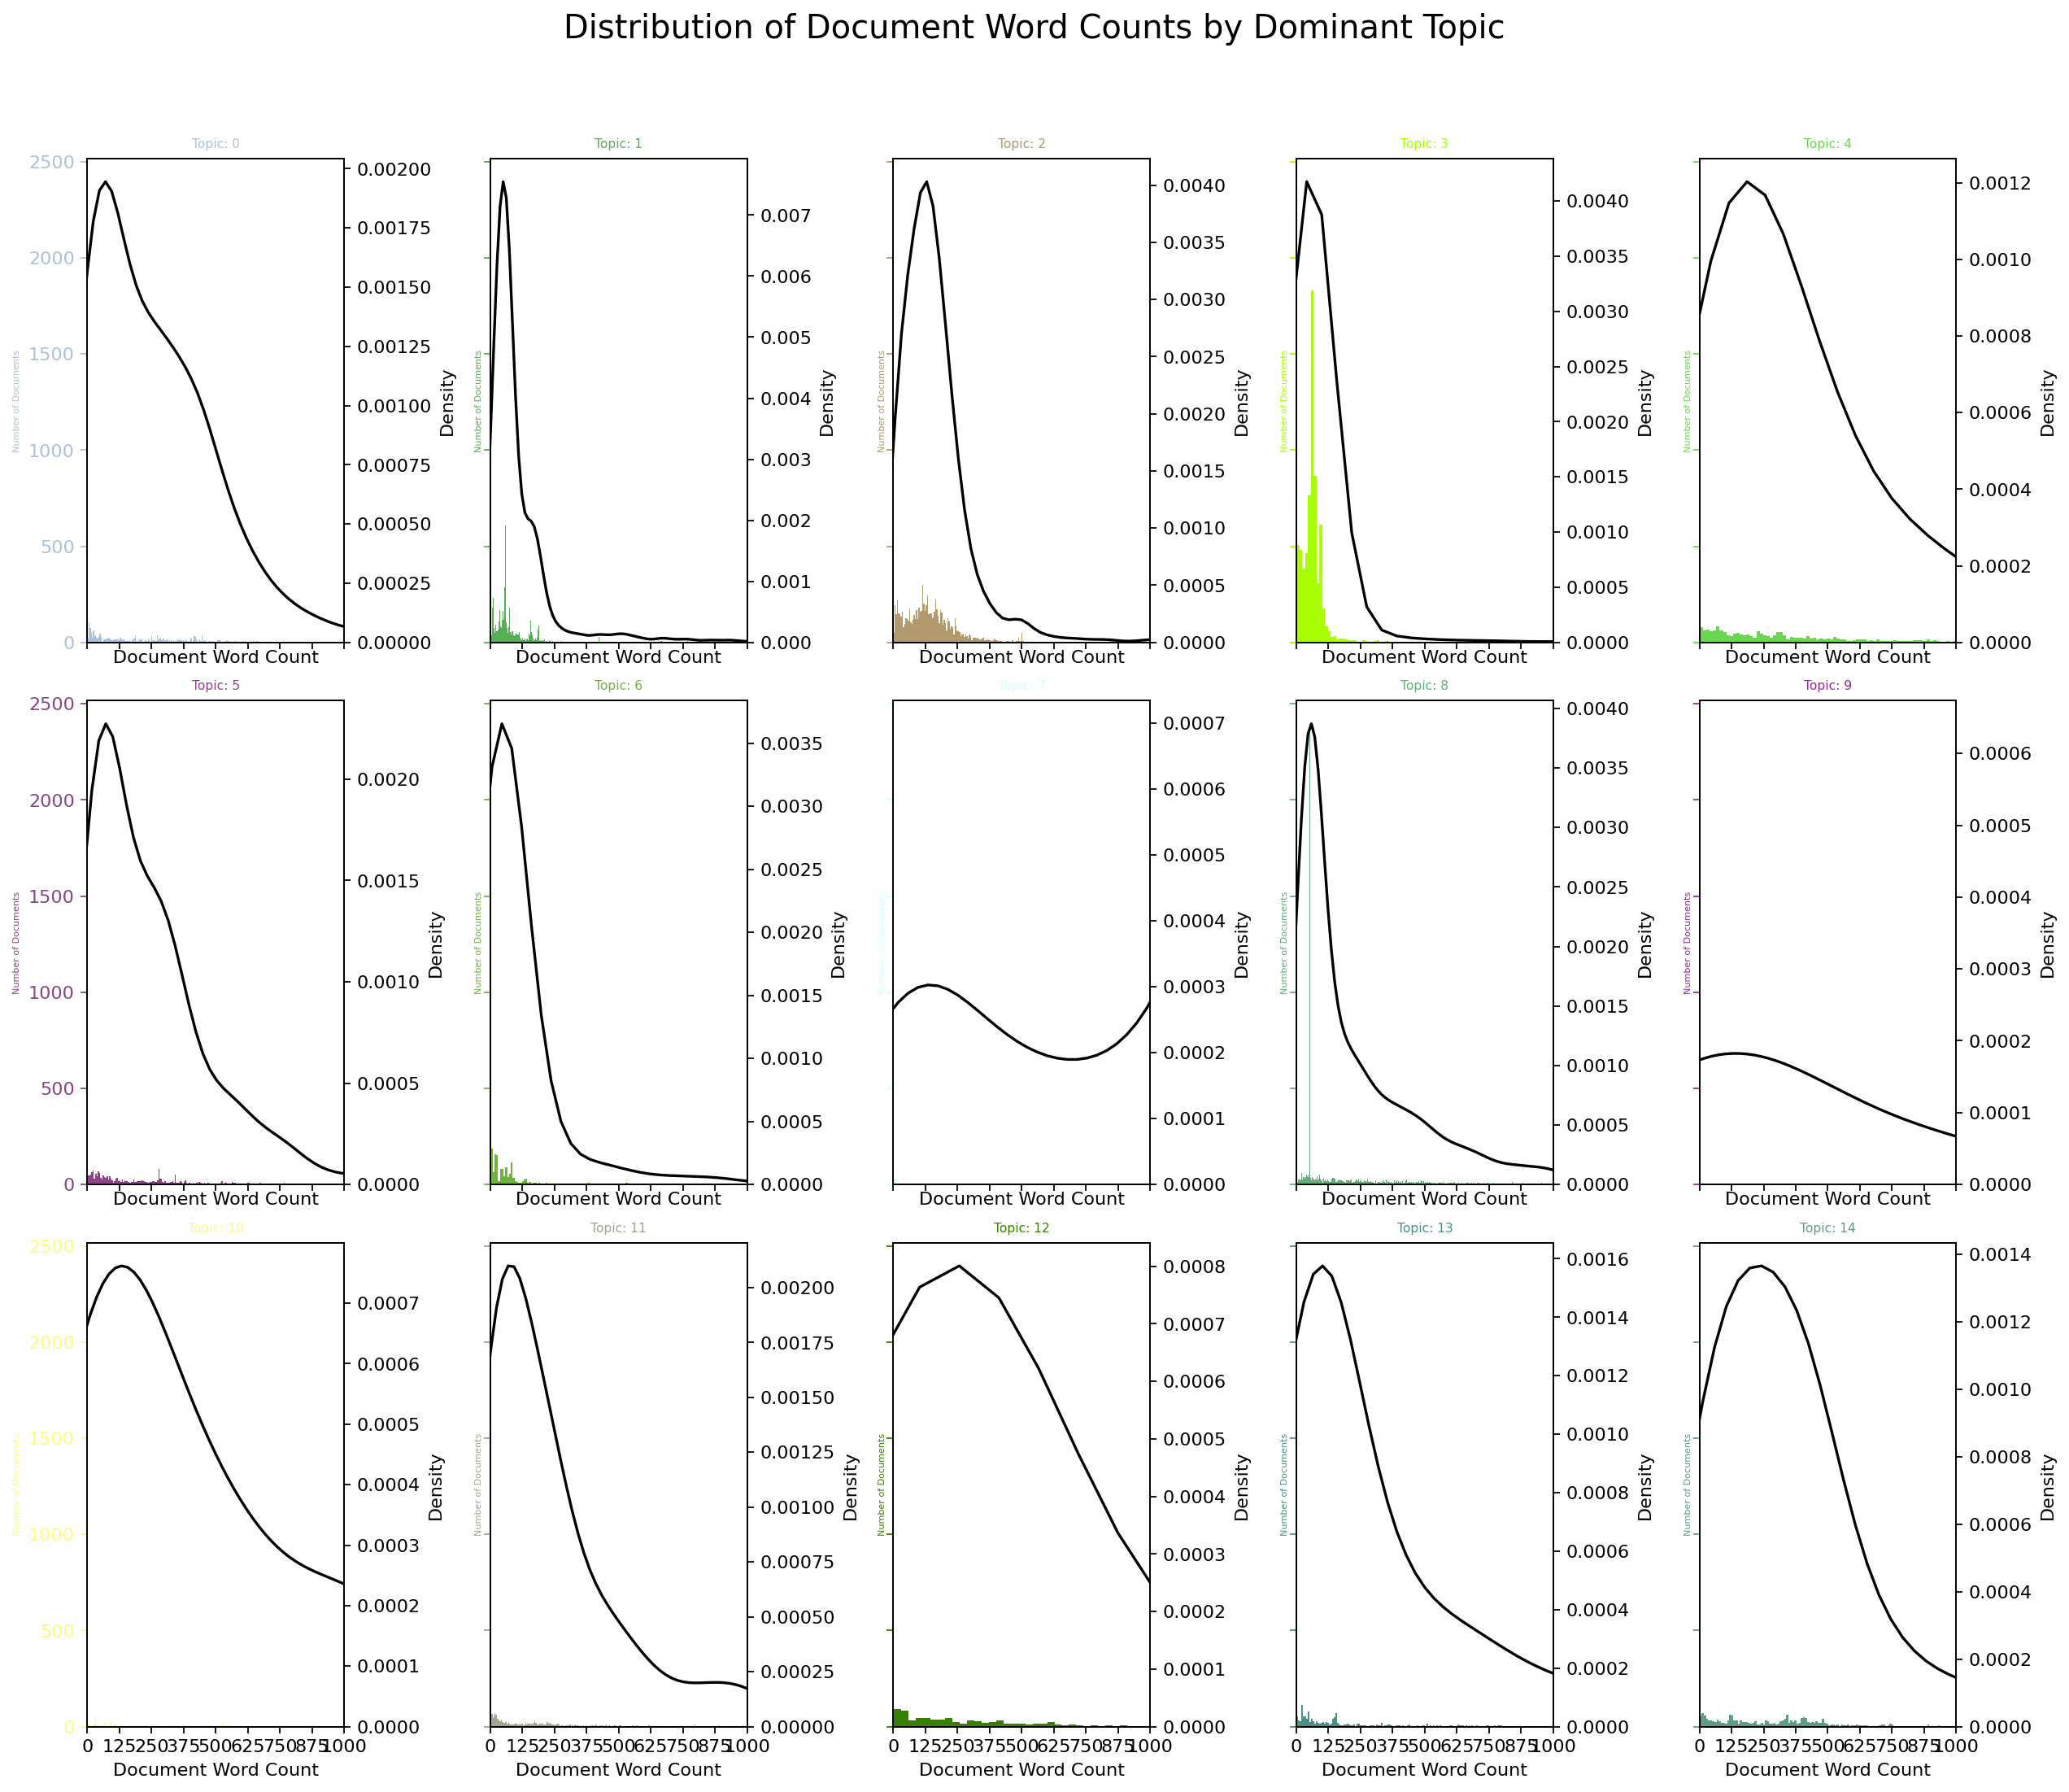

In [57]:
import seaborn as sns

def topics_document_words_freq_plot(df_dominant_topic):
    cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    fig, axes = plt.subplots(3, 5, figsize=(16, 14), dpi=160, sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, bins=1000, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
        ax.set(xlim=(0, 1000), xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i], fontdict=dict(size=5))
        ax.set_title('Topic: ' + str(i), fontdict=dict(size=7, color=cols[i]))

    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.xticks(np.linspace(0, 1000, 9))
    fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=18)
    plt.show()

topics_document_words_freq_plot(df_dominant_topic)

## Word count and importance of topic keywords

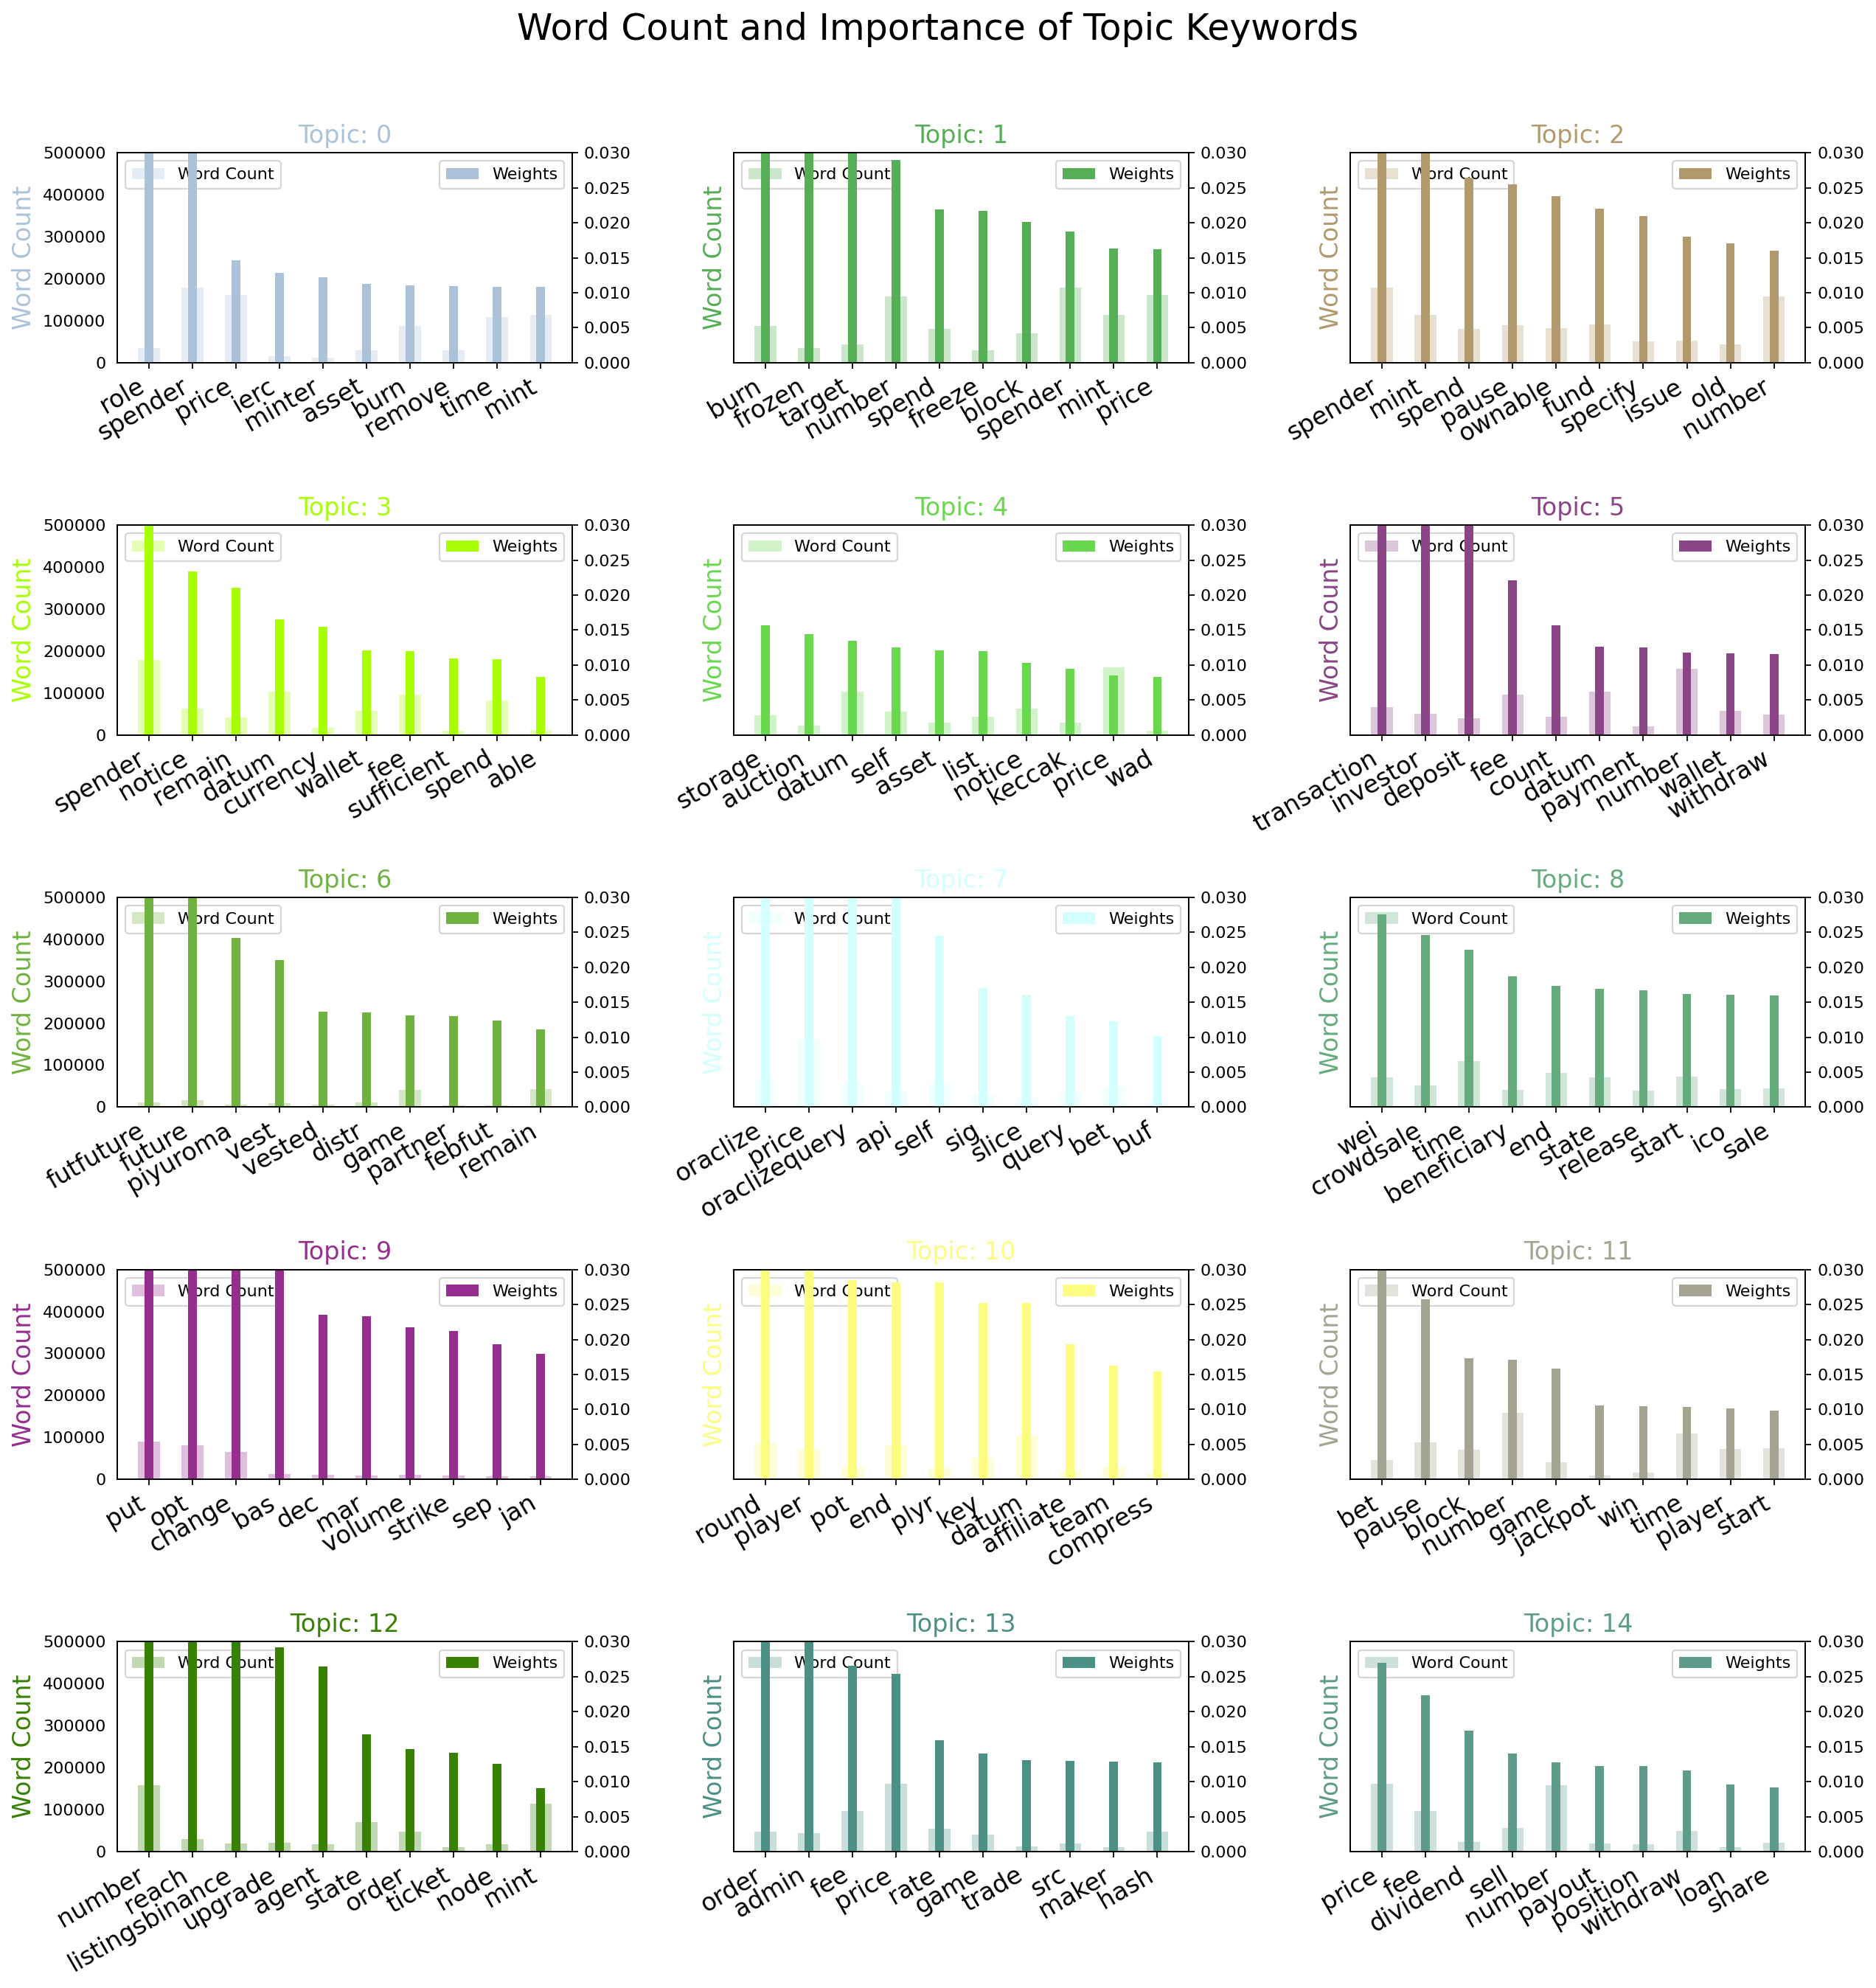

In [61]:
from collections import Counter

topics = lda_model.show_topics(formatted=False, num_topics=15)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)


out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])



fig, axes = plt.subplots(5, 3, figsize=(16, 16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3,
               label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.2,
                    label='Weights')
    ax.set_ylabel('Word Count', color=cols[i], fontdict=dict(size=15))
    ax_twin.set_ylim(0, 0.030);
    ax.set_ylim(0, 500000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=15)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right',
                           fontdict=dict(size=15))
    ax.legend(loc='upper left');
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=0.02)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

## Distribution of document word counts

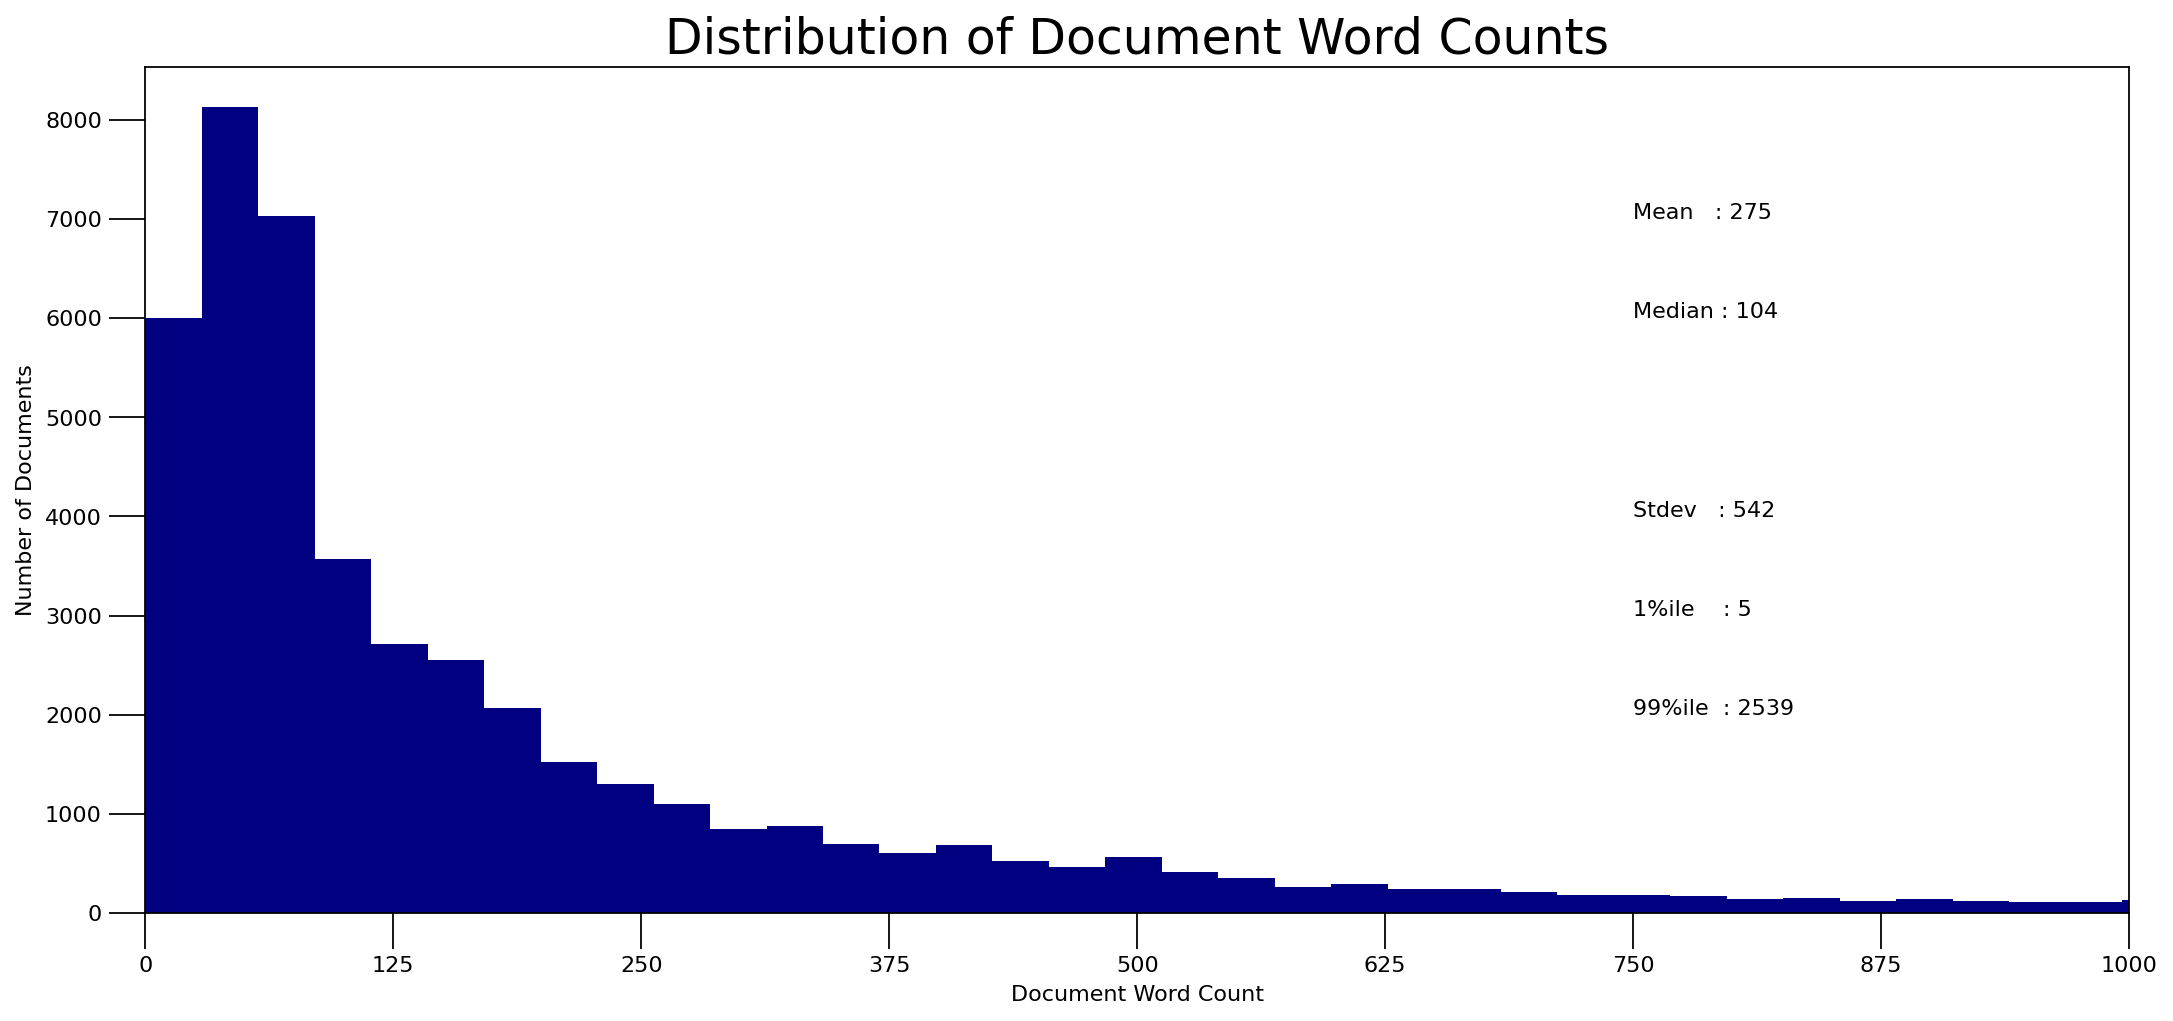

In [62]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16, 7), dpi=160)
plt.hist(doc_lens, bins=1000, color='navy')
plt.text(750, 7000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 6000, "Median : " + str(round(np.median(doc_lens))))
plt.text(750, 4000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750, 3000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750, 2000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 1000, 9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

## Conclusioni
Dopo aver estratto il linguaggio naturale presente negli
smart contracts tramite un lavoro di preprocessing, è stato costruito un topic model usando Gensim’ s LDA e
sono stati visualizzati i topics usando il modulo pyLDAvis.
Il numero ottimale di di topics è stato trovato confrontando
la coherence score di 7 modelli costruiti rispettivamente
con un numero diverso di topics.
Si è cercato di offrire un'interpretazione
dei vari topics individuati dall'algoritmo LDA e si
è esplorata la loro distribuzione e la frequenza delle parole.

